# Effect of compound kernels on GP fit

This notebook examines the incremental affect of adding more terms to the GP kernel expression, namely Squared Exponential (SE), Matern $\frac{3}{2}$ (M32), and Periodic kernels (P).

There is the possibility of degeneracy between the various hyperparameters of the chosen kernels, especially the overlapping influences on input and output scale parameters ($\ell$ and $\eta$).

Four light curves taken from the ThunderKAT survey have been selected as test cases:
- `80_ra271.352_dec-29.642_MAXIJ1803`: evenly spaced, no obvious outliers, weak correlated noise.
- `1817_ra284.905_dec-8.658_J1858TraPDB`: non-stationary series.
- `428_ra236.530_dec-46.922_4U1543TraPDB`: evenly spaced, no obvious outliers, moderate correlated noise.
- `502_ra236.310_dec-47.644_4U1543TraPDB`: bi-modal distribution in observational errors.

For a light curve each of the following models is fitted:

1. GP using SE kernel
2. GP using M32 kernel
3. GP using SE + M32 kernel
4. GP using SE $\times$ M32 kernel
5. Sum of SE GP and M32 GP


In [65]:
from pathlib import Path
import numpy as np
import arviz as az
import graphviz as gv
import utility_functions as ufn
import importlib

importlib.reload(ufn)
az.style.use("arviz-white")

RANDOM_SEED = 2023-10-10
rng = np.random.default_rng(RANDOM_SEED)

OVERWRITE_TRACES = False

In [66]:
# File paths to CSVs of flux density observations.
csv_paths_list = sorted(list(Path('data_raw').iterdir()))
csv_paths_list

[PosixPath('data_raw/1817_ra284.905_dec-8.658_J1858TraPDB_andersson.csv'),
 PosixPath('data_raw/428_ra236.530_dec-46.922_4U1543TraPDB_andersson.csv'),
 PosixPath('data_raw/502_ra236.310_dec-47.644_4U1543TraPDB_andersson.csv'),
 PosixPath('data_raw/80_ra271.352_dec-29.642_MAXIJ1803TraPDB_andersson.csv')]

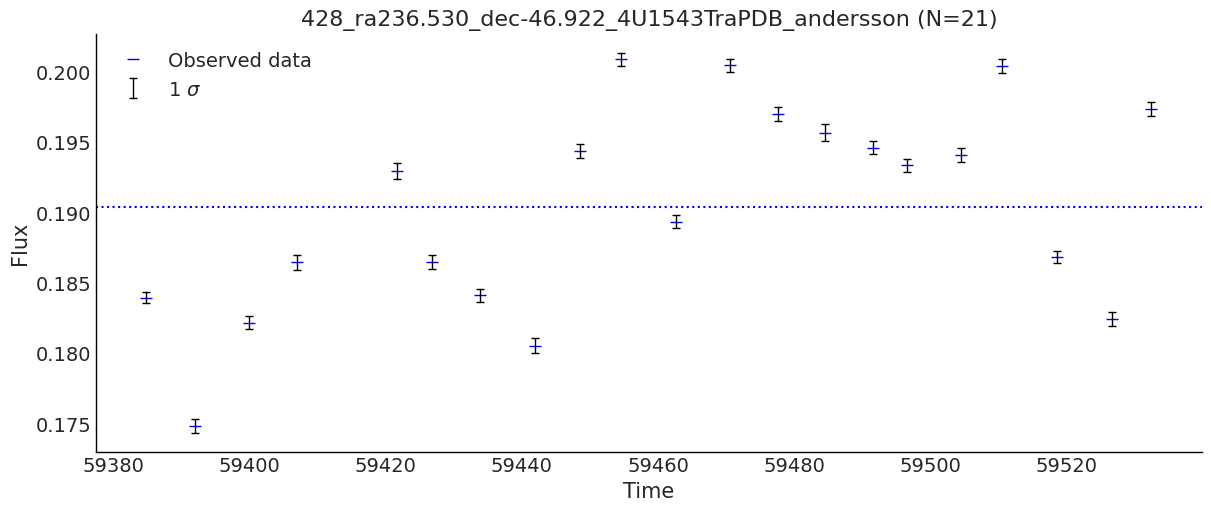

In [67]:
csv_path = csv_paths_list[1]
ufn.plot_lc(csv_path)

## SE Kernel only

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\textrm{SE}(\tau))$$

$$k_\textrm{SE}(\tau) = \eta^2_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{SE} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN},i} \sim \textrm{HalfNormal}(e_i^2)$$

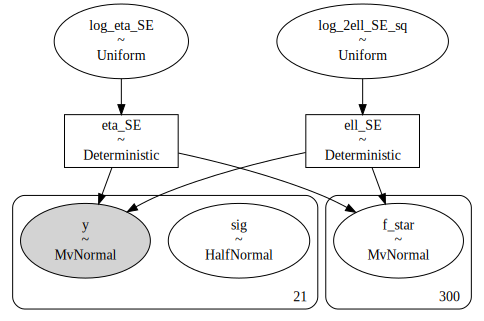

In [68]:
se_trace_path = Path(f"traces/{csv_path.stem}_se_idata.nc")
se_dag_path = Path(f'dags/{csv_path.stem}_se_dag.dot')

if se_trace_path.is_file() and not OVERWRITE_TRACES:
    se_trace = az.from_netcdf(se_trace_path)
    se_dag = gv.Source.from_file(se_dag_path)
else:
    se_trace, se_dag = ufn.fit_se_gp(csv_path, rng_seed=rng);
    az.to_netcdf(se_trace, se_trace_path)
    with open(se_dag_path, 'w') as writehandle:
        writehandle.write(se_dag.source)

gv.Source(se_dag.source)

In [69]:
variable_names = ["log_2ell_SE_sq", "log_eta_SE", "ell_SE", "eta_SE"]
ufn.print_post_summary(se_trace_path, variable_names)

median       mad    eti_16%    eti_84%  mcse_median  \
log_2ell_SE_sq   5.706069  0.070757   5.594420   5.807848     0.001971   
log_eta_SE      -1.989372  0.130472  -2.168828  -1.774318     0.003507   
ell_SE          12.261457  0.435035  11.595724  12.901587     0.012087   
eta_SE           0.136781  0.017586   0.114312   0.169599     0.000479   

                 ess_median     ess_tail     r_hat       mean        sd  
log_2ell_SE_sq  3435.024402  2857.820642  1.002410   5.701887  0.108913  
log_eta_SE      3695.837619  2384.348100  1.002178  -1.974444  0.199744  
ell_SE          3435.024402  2857.820642  1.002505  12.253905  0.662593  
eta_SE          3695.837619  2384.348100  1.002146   0.141715  0.029839

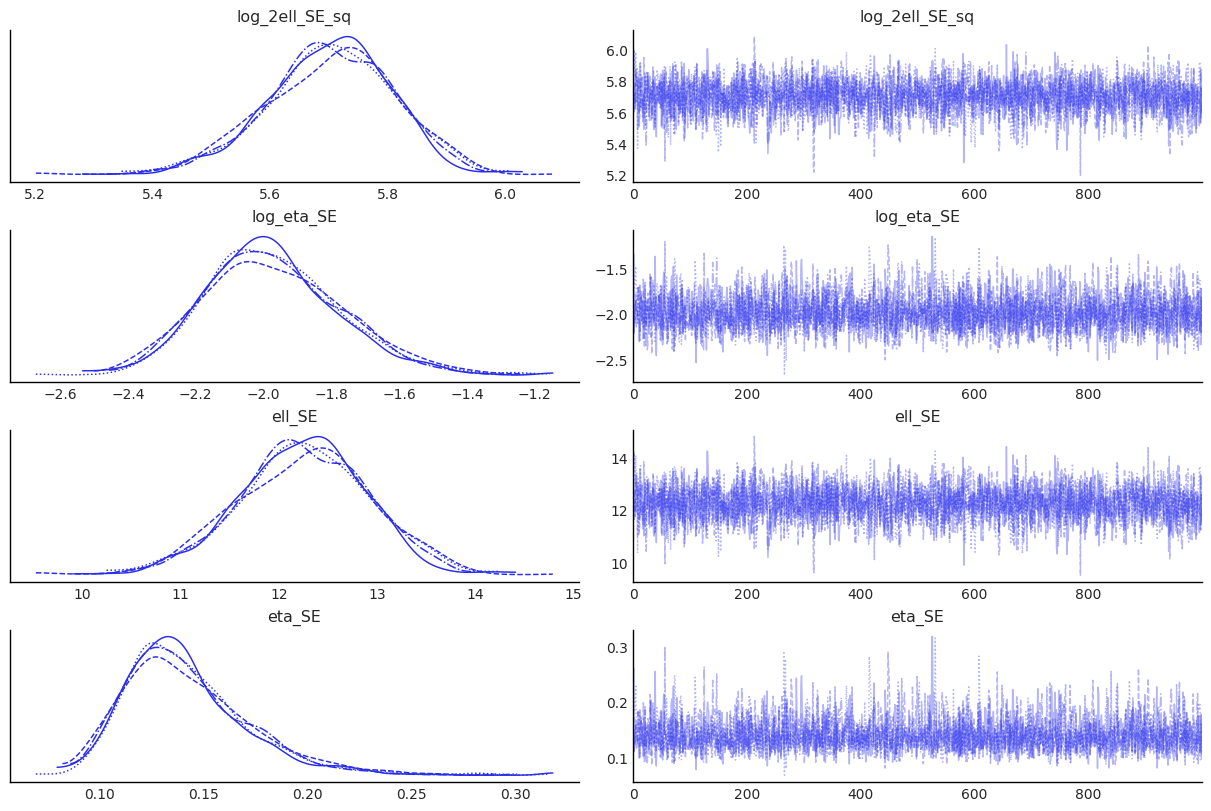

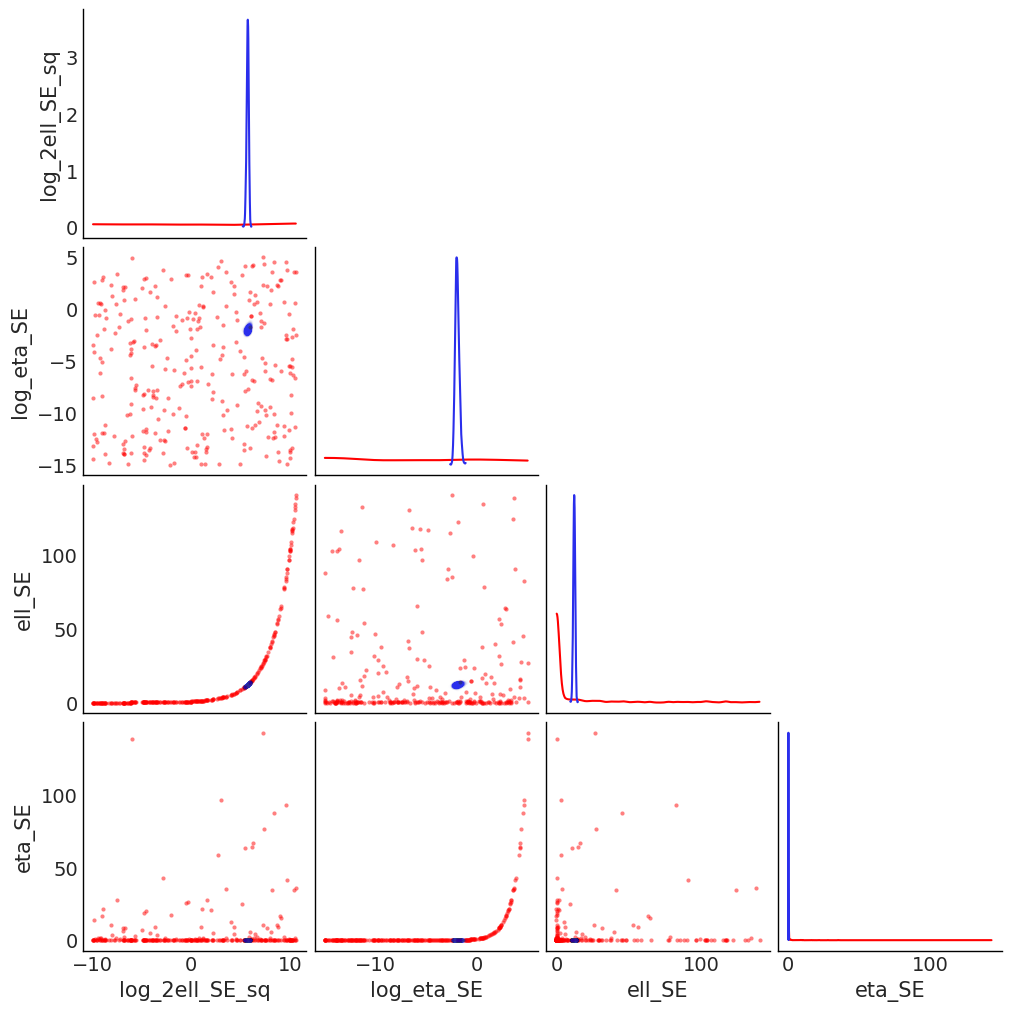

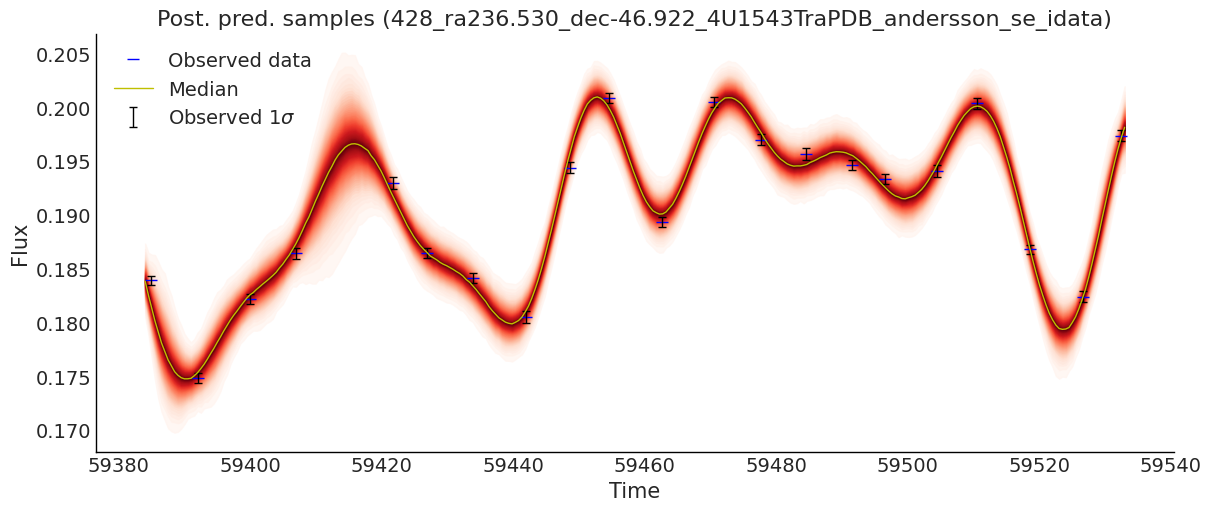

In [70]:
ufn.plot_traces(se_trace_path, variable_names)
ufn.plot_priorpost_cnr(se_trace_path, variable_names)
ufn.plot_postpred_samples(se_trace_path, csv_path)

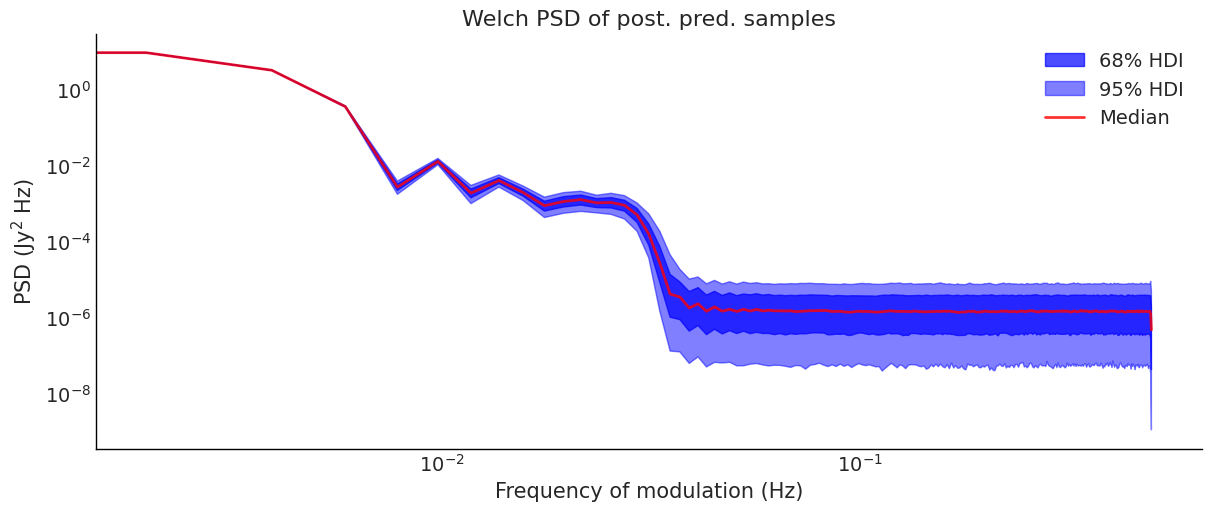

In [71]:
ufn.plot_welch_psd(se_trace);

## Matern $\frac{3}{2}$ Kernel only

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\textrm{M}(\tau))$$

$$k_\textrm{M}(\tau) =  \eta_\textrm{M}^2\left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{M} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

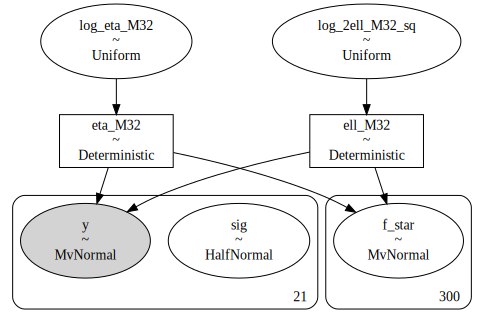

In [72]:
m32_trace_path = Path(f"traces/{csv_path.stem}_m32_idata.nc")
m32_dag_path = Path(f'dags/{csv_path.stem}_m32_dag.dot')

if m32_trace_path.is_file() and not OVERWRITE_TRACES:
    m32_trace = az.from_netcdf(m32_trace_path)
    m32_dag = gv.Source.from_file(m32_dag_path)
else:
    m32_trace, m32_dag = ufn.fit_m32_gp(csv_path, rng_seed=rng);
    az.to_netcdf(m32_trace, m32_trace_path)
    with open(m32_dag_path, 'w') as writehandle:
        writehandle.write(m32_dag.source)

gv.Source(m32_dag.source)

In [73]:
variable_names = ["log_2ell_M32_sq", "log_eta_M32", "ell_M32", "eta_M32"]
ufn.print_post_summary(m32_trace_path, variable_names)

median        mad    eti_16%     eti_84%  mcse_median  \
log_2ell_M32_sq   9.833182   0.370721   9.297615   10.355826     0.014078   
log_eta_M32      -1.712483   0.243083  -2.058235   -1.354654     0.011144   
ell_M32          96.545788  17.548717  73.864621  125.378806     0.679986   
eta_M32           0.180417   0.042961   0.127679    0.258036     0.002011   

                  ess_median     ess_tail     r_hat       mean         sd  
log_2ell_M32_sq  2550.679246  1021.630258  1.003224   9.814164   0.493340  
log_eta_M32      2207.795201  1663.363218  1.002422  -1.707090   0.338707  
ell_M32          2550.679246  1021.630258  1.003224  98.508788  23.556763  
eta_M32          2207.795201  1663.363218  1.002422   0.192126   0.066669

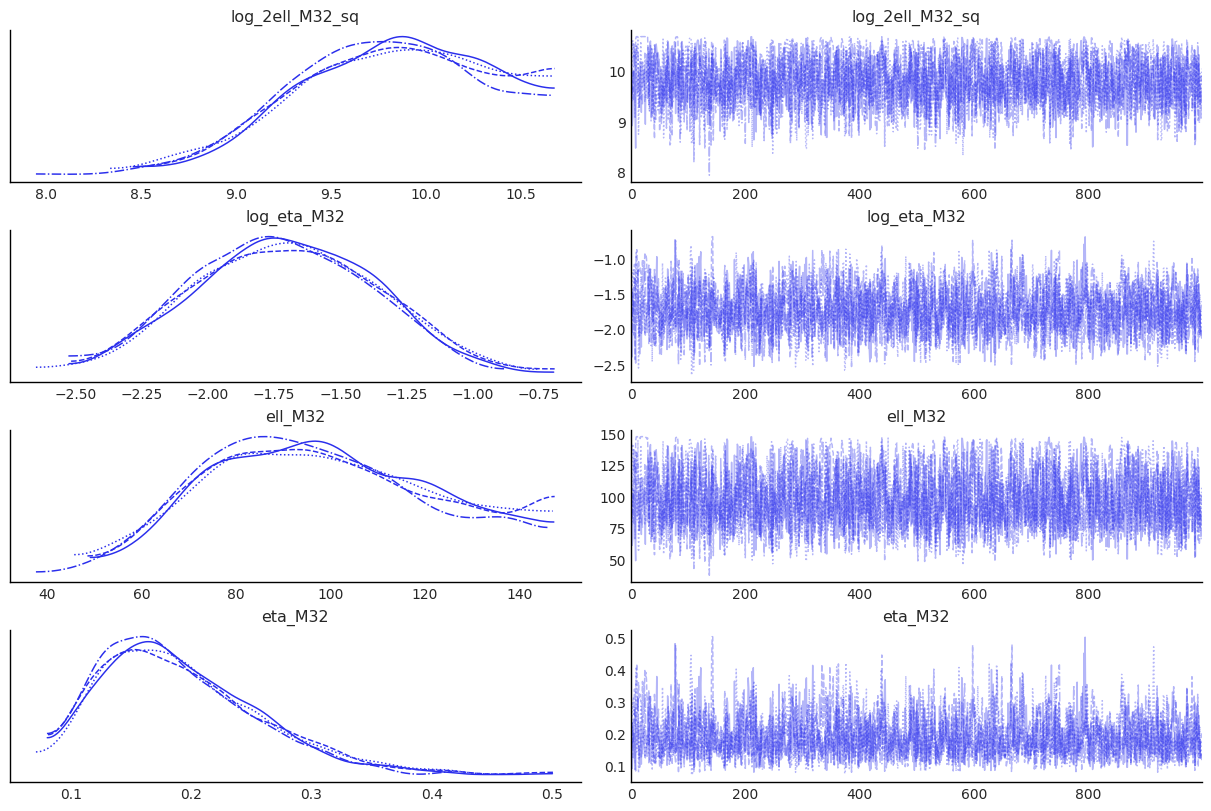

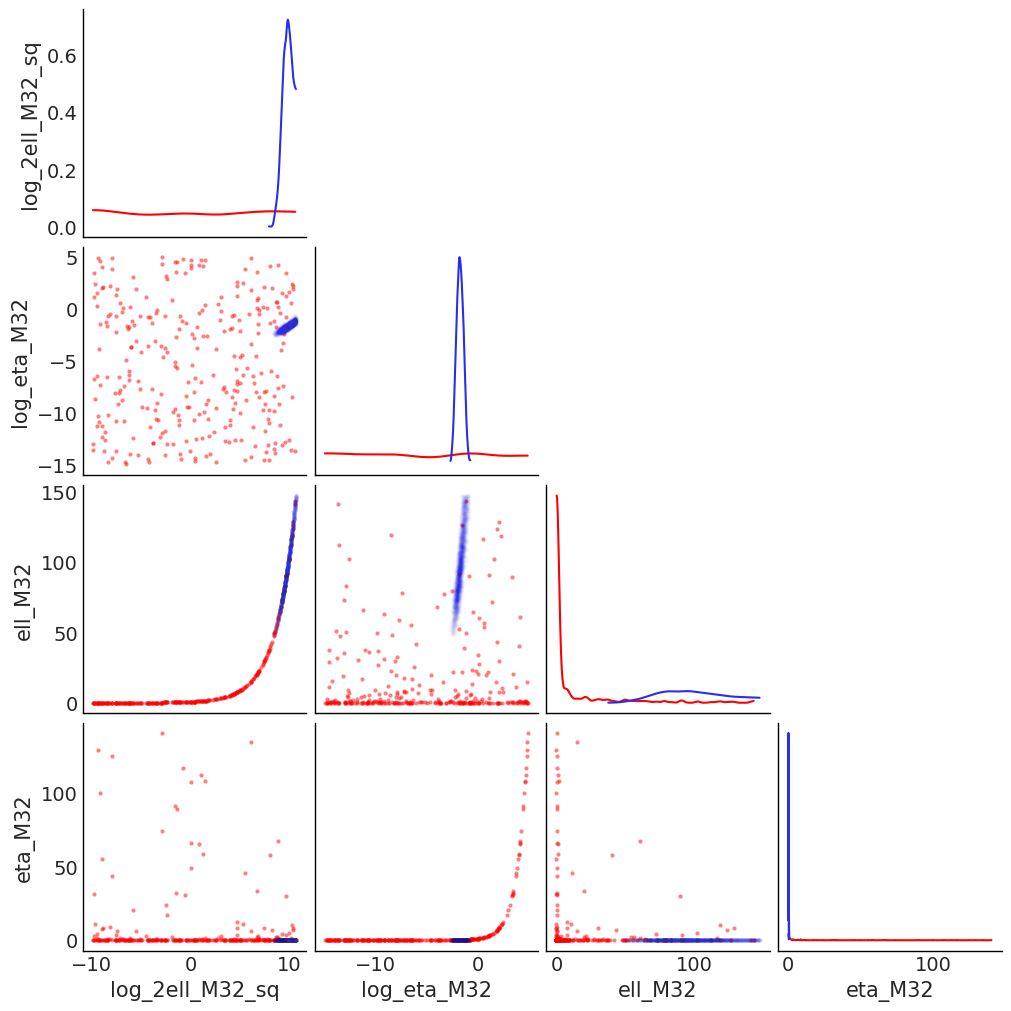

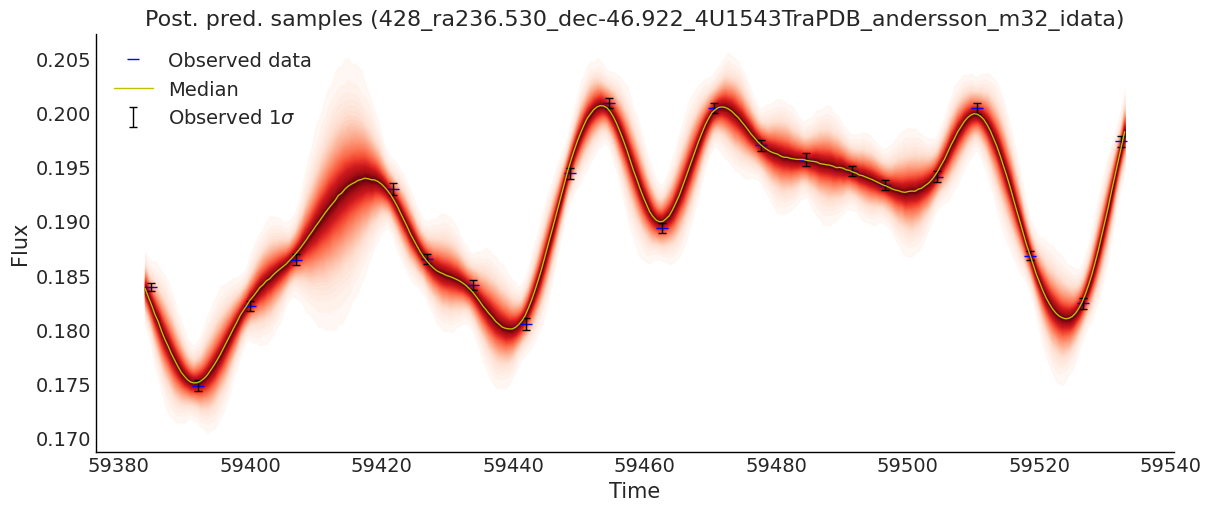

In [74]:
ufn.plot_traces(m32_trace_path, variable_names)
ufn.plot_priorpost_cnr(m32_trace_path, variable_names)
ufn.plot_postpred_samples(m32_trace_path, csv_path)

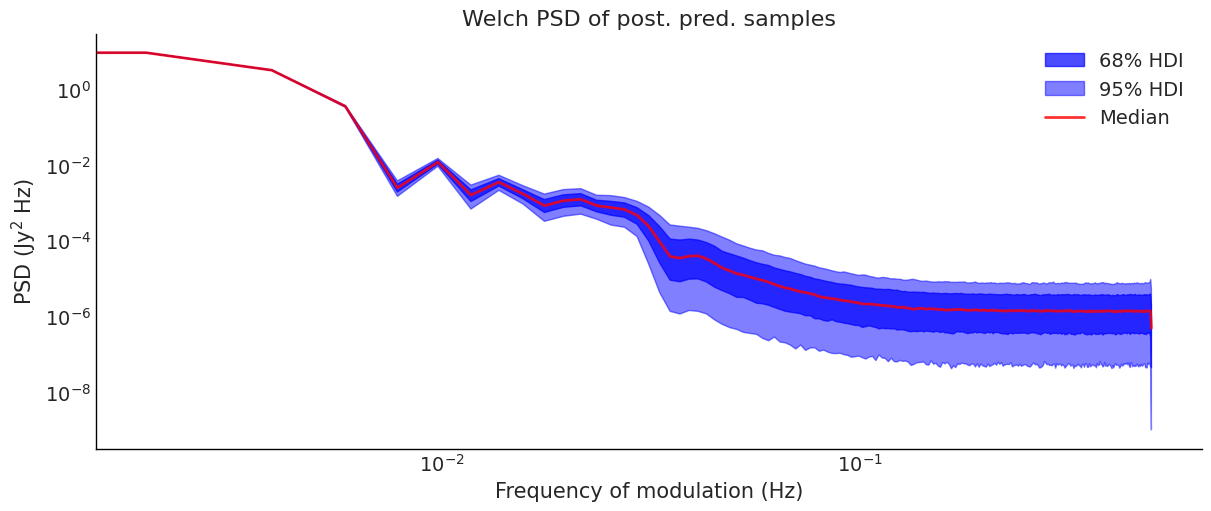

In [75]:
ufn.plot_welch_psd(m32_trace);

## SE + Matern $\frac{3}{2}$ additive kernel

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\textrm{SE+M}(\tau))$$

$$k_\textrm{SE+M}(\tau) = \eta^2_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\} + \eta^2_\textrm{M}\left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{SE} \sim \mathcal{U}[-15, 5]$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{M} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

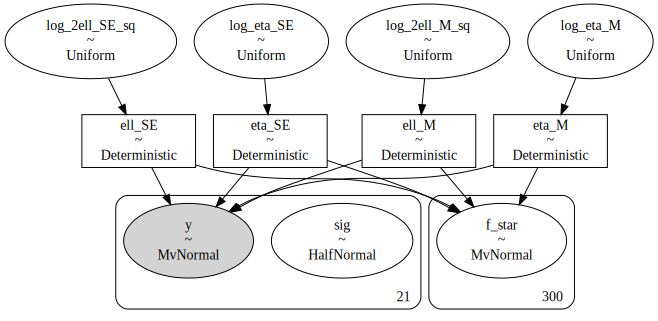

In [76]:
sem32_trace_path = Path(f"traces/{csv_path.stem}_se+m32_idata.nc")
sem32_dag_path = Path(f'dags/{csv_path.stem}_se+m32_dag.dot')

if sem32_trace_path.is_file() and not OVERWRITE_TRACES:
    sem32_trace = az.from_netcdf(sem32_trace_path)
    sem32_dag = gv.Source.from_file(sem32_dag_path)
else:
    sem32_trace, sem32_dag = ufn.fit_sem32_gp(csv_path, multiplicative_kernel=False, rng_seed=rng);
    az.to_netcdf(sem32_trace, sem32_trace_path)
    with open(sem32_dag_path, 'w') as writehandle:
        writehandle.write(sem32_dag.source)

gv.Source(sem32_dag.source)

In [77]:
variable_names = ["log_2ell_SE_sq", "log_2ell_M_sq", "log_eta_SE", "log_eta_M"]
ufn.print_post_summary(sem32_trace_path, variable_names)

median       mad   eti_16%    eti_84%  mcse_median  \
log_2ell_SE_sq  10.376309  0.217460  9.782749  10.606307     0.067590   
log_2ell_M_sq   -1.754519  3.864543 -7.155183   3.560580     0.977347   
log_eta_SE      -2.103090  0.274411 -2.521403  -1.663519     0.068382   
log_eta_M       -5.110600  0.144910 -5.301557  -4.831714     0.037792   

                ess_median   ess_tail     r_hat      mean        sd  
log_2ell_SE_sq   44.476146  10.985123  1.191448  9.140179  3.922638  
log_2ell_M_sq    54.458416  11.155933  1.203604 -1.281560  5.498333  
log_eta_SE       48.821029  10.944151  1.197159 -2.418844  1.462375  
log_eta_M        47.063712  11.095774  1.202357 -4.821895  0.926908

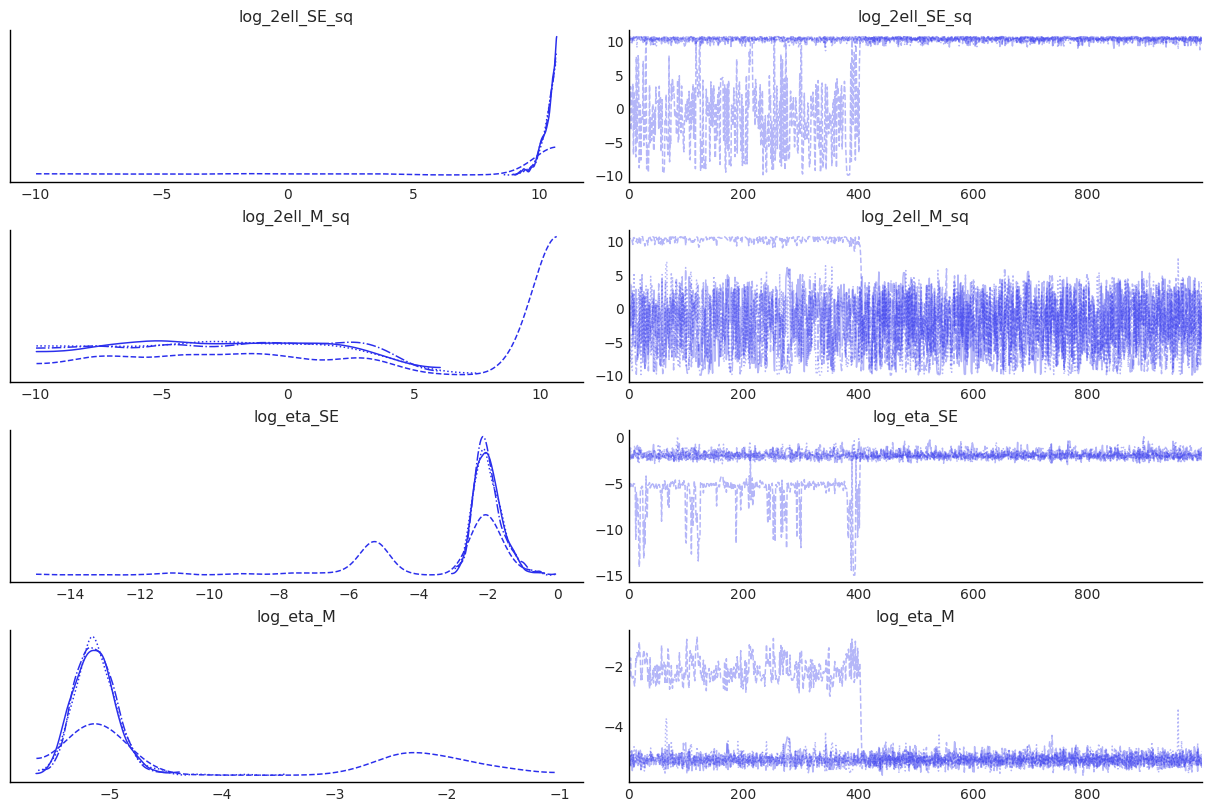

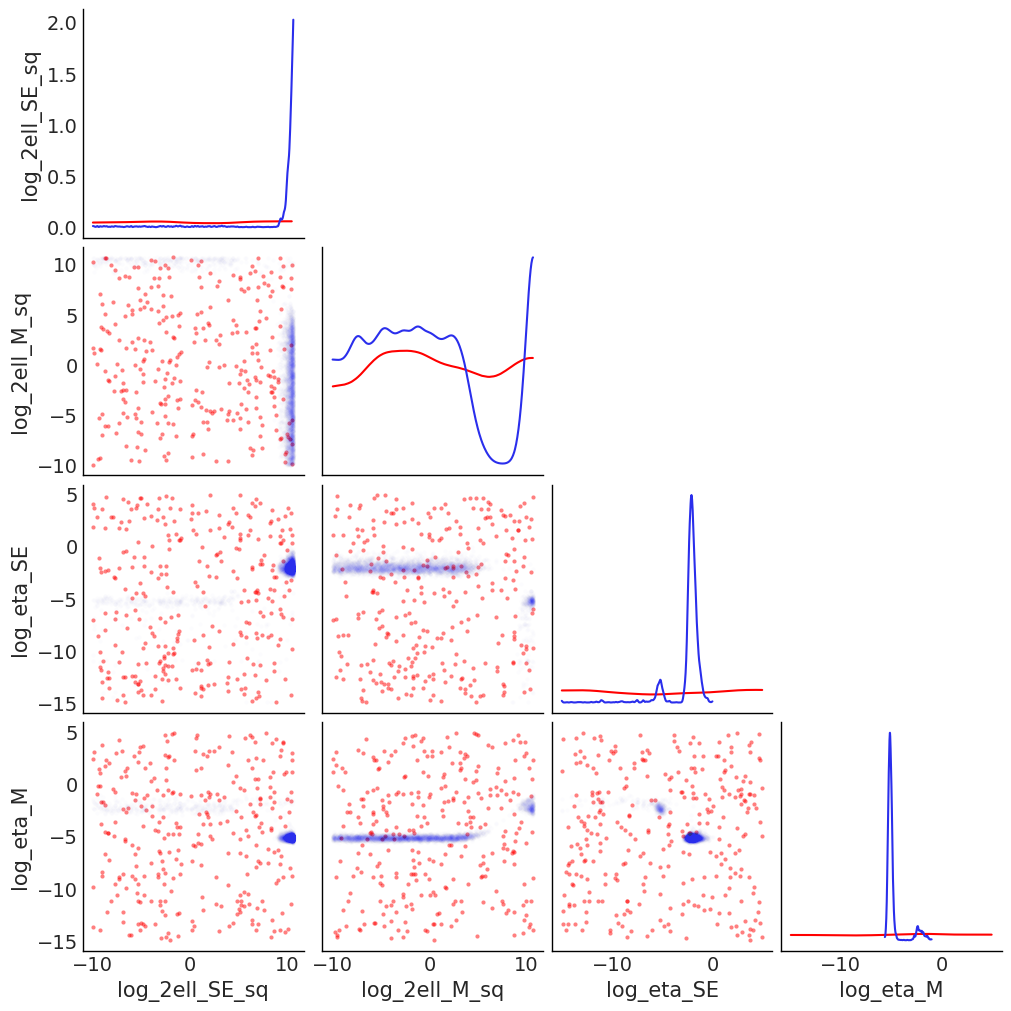

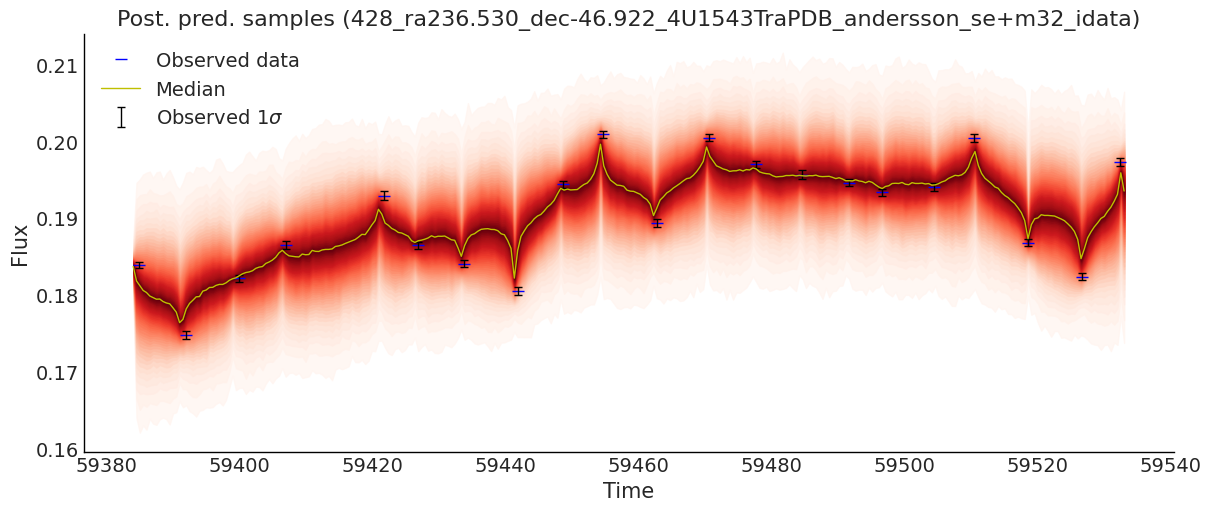

In [78]:
ufn.plot_traces(sem32_trace_path, variable_names)
ufn.plot_priorpost_cnr(sem32_trace_path, variable_names)
ufn.plot_postpred_samples(sem32_trace_path, csv_path)

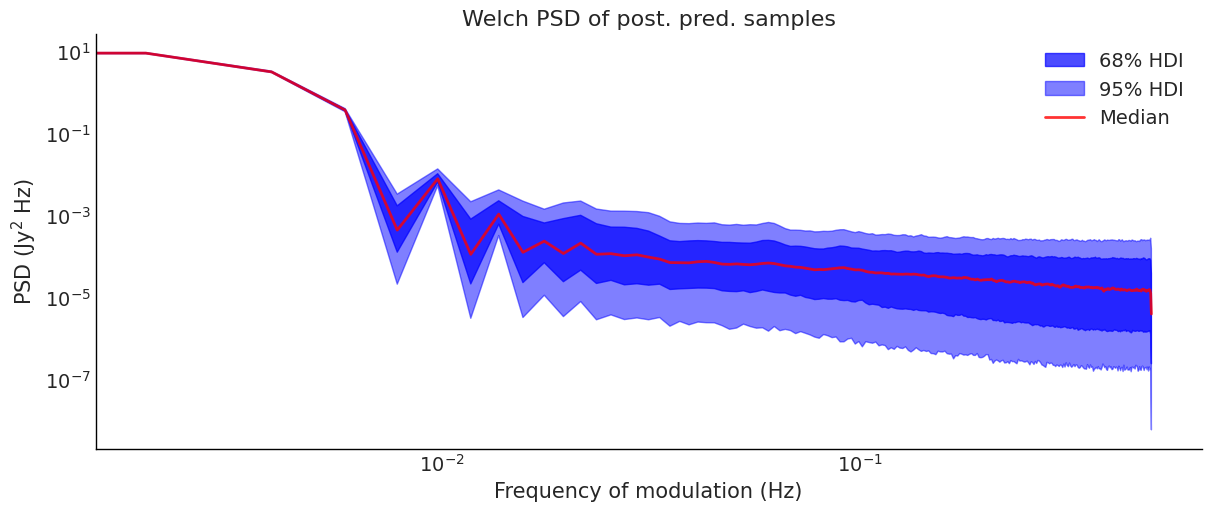

In [79]:
ufn.plot_welch_psd(sem32_trace);

## SE GP + Matern $\frac{3}{2}$ GP

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{GP}(\boldsymbol{0}, k_\textrm{SE}(\tau)) + \mathcal{GP}(\boldsymbol{0}, k_\textrm{M}(\tau))$$

$$k_\textrm{SE}(\tau) = \eta^2_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\}, \quad k_\textrm{M}(\tau) = \eta^2_\textrm{M}\left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{SE} \sim \mathcal{U}[-15, 5]$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{M} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

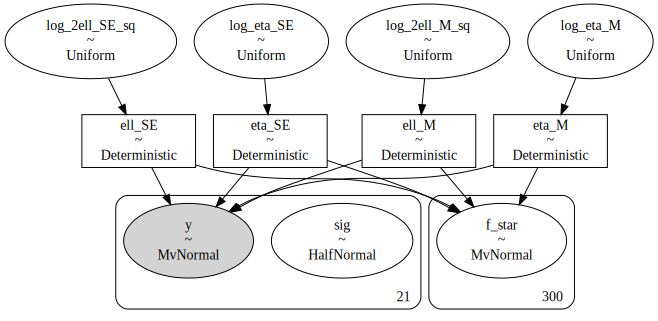

In [80]:
gpSE_gpM32_trace_path = Path(f"traces/{csv_path.stem}_gpSE_gpM32_idata.nc")
gpSE_gpM32_dag_path = Path(f'dags/{csv_path.stem}_gpSE_gpM32_dag.dot')

if gpSE_gpM32_trace_path.is_file() and not OVERWRITE_TRACES:
    gpSE_gpM32_trace = az.from_netcdf(gpSE_gpM32_trace_path)
    gpSE_gpM32_dag = gv.Source.from_file(gpSE_gpM32_dag_path)
else:
    gpSE_gpM32_trace, gpSE_gpM32_dag = ufn.fit_sem32_gp(csv_path, multiplicative_kernel=False, rng_seed=rng);
    az.to_netcdf(gpSE_gpM32_trace, gpSE_gpM32_trace_path)
    with open(gpSE_gpM32_dag_path, 'w') as writehandle:
        writehandle.write(gpSE_gpM32_dag.source)

gv.Source(gpSE_gpM32_dag.source)

In [81]:
variable_names = ["log_2ell_SE_sq", "log_2ell_M_sq", "log_eta_SE", "log_eta_M"]
ufn.print_post_summary(gpSE_gpM32_trace_path, variable_names)

median       mad   eti_16%    eti_84%  mcse_median  \
log_2ell_SE_sq  10.378886  0.219010  9.599153  10.609538     0.086866   
log_2ell_M_sq   -1.969417  4.222521 -7.412947   4.304652     1.531146   
log_eta_SE      -2.118980  0.317736 -2.643658  -1.637710     0.102871   
log_eta_M       -5.100802  0.151530 -5.295054  -4.724376     0.049832   

                ess_median   ess_tail     r_hat      mean        sd  
log_2ell_SE_sq   28.840885  13.809363  1.297137  8.813033  4.396331  
log_2ell_M_sq    30.100660  13.212094  1.312017 -1.195845  5.934768  
log_eta_SE       29.256403  15.298749  1.300278 -2.651030  1.998063  
log_eta_M        29.026067  12.931962  1.304000 -4.719954  1.061865

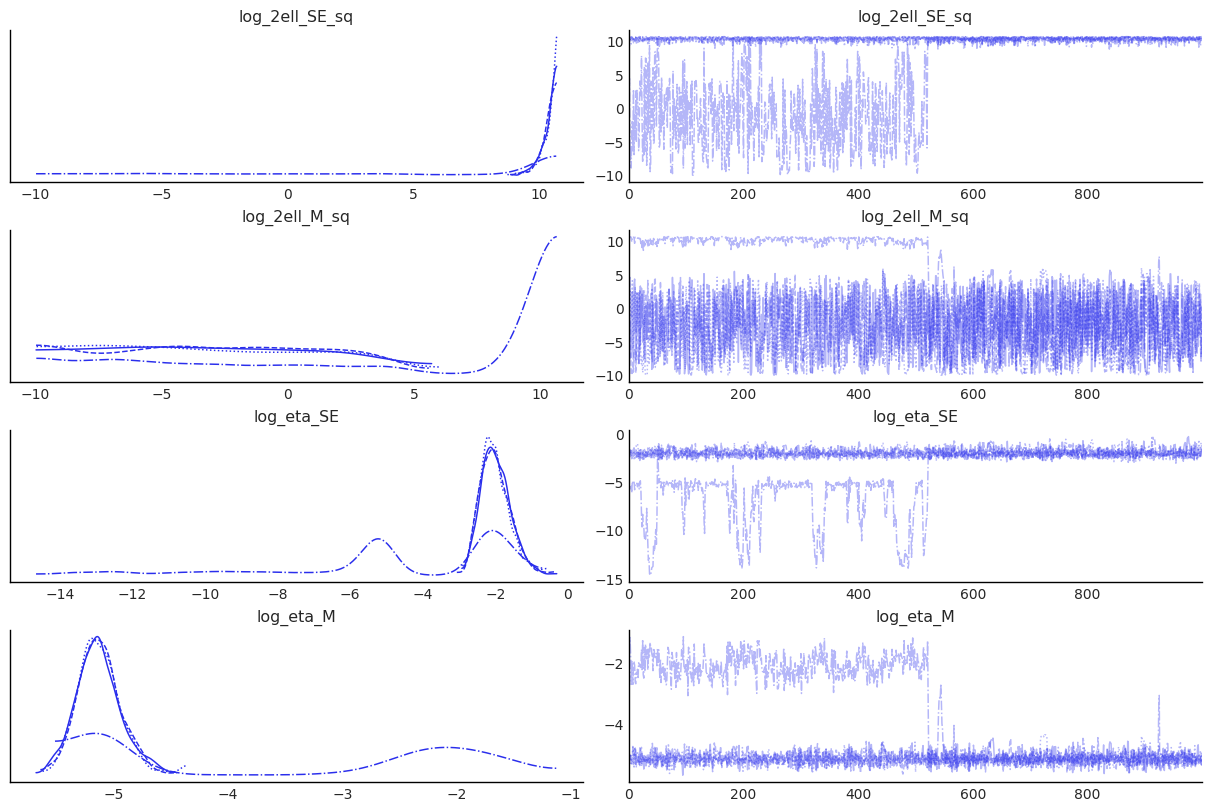

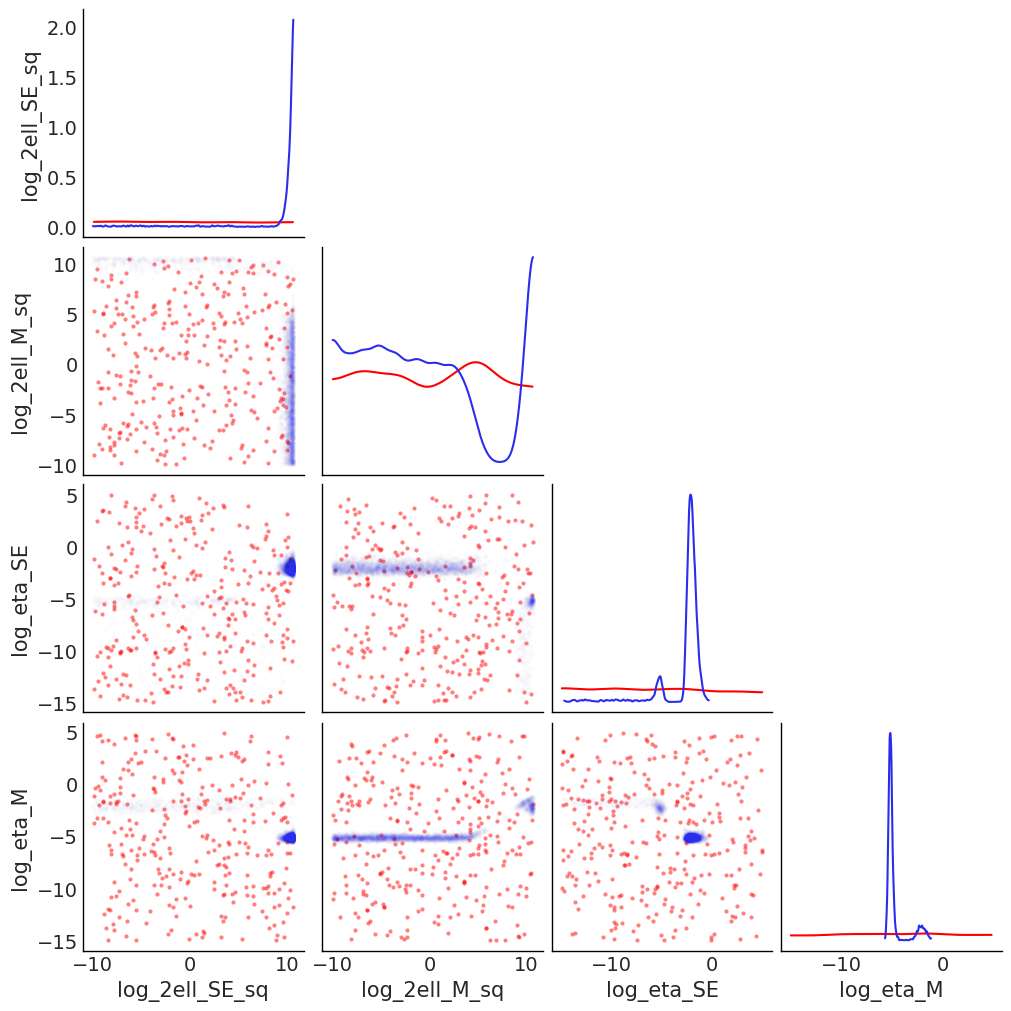

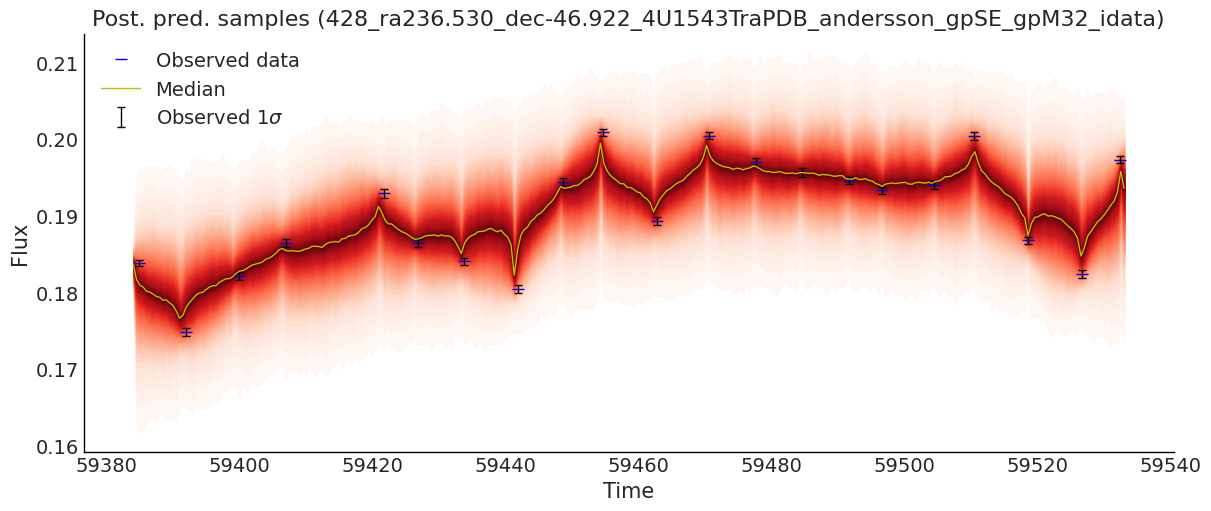

In [82]:
ufn.plot_traces(gpSE_gpM32_trace_path, variable_names)
ufn.plot_priorpost_cnr(gpSE_gpM32_trace_path, variable_names)
ufn.plot_postpred_samples(gpSE_gpM32_trace_path, csv_path)

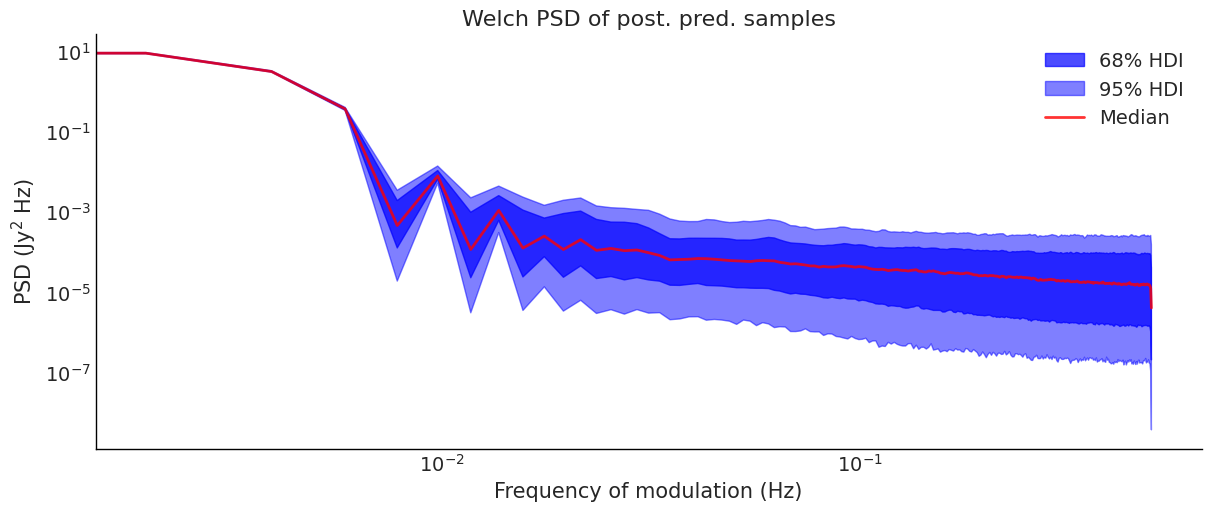

In [83]:
ufn.plot_welch_psd(gpSE_gpM32_trace);

## SE $\times$ Matern $\frac{3}{2}$ Multiplicative Kernel

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\mathrm{SE \times M}(\tau))$$

$$k_\mathrm{SE \times M}(\tau) = \eta^2\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\} \left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta \sim \mathcal{U}[-15, 5]$$


$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

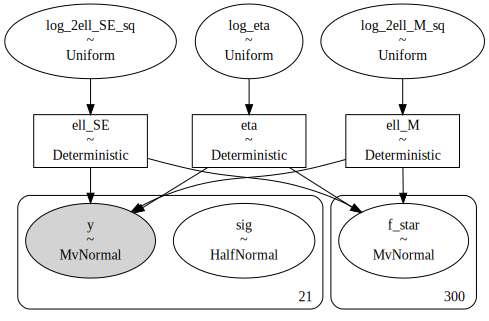

In [84]:
sexm32_trace_path = Path(f"traces/{csv_path.stem}_sexm32_idata.nc")
sexm32_dag_path = Path(f'dags/{csv_path.stem}_sexm32_dag.dot')

if sexm32_trace_path.is_file() and not OVERWRITE_TRACES:
    sexm32_trace = az.from_netcdf(sexm32_trace_path)
    sexm32_dag = gv.Source.from_file(sexm32_dag_path)
else:
    sexm32_trace, sexm32_dag = ufn.fit_sem32_gp(csv_path, multiplicative_kernel=True, rng_seed=rng);
    az.to_netcdf(sexm32_trace, sexm32_trace_path)
    with open(sexm32_dag_path, 'w') as writehandle:
        writehandle.write(sexm32_dag.source)

gv.Source(sexm32_dag.source)

In [85]:
variable_names = ["log_2ell_SE_sq", "log_2ell_M_sq", "log_eta"]
ufn.print_post_summary(sexm32_trace_path, variable_names)

median       mad   eti_16%    eti_84%  mcse_median  \
log_2ell_SE_sq  10.011135  0.413228  9.283467  10.485369     0.013868   
log_2ell_M_sq    9.757901  0.366566  9.237349  10.300199     0.013283   
log_eta         -1.748631  0.247260 -2.083906  -1.389735     0.009333   

                 ess_median     ess_tail     r_hat      mean        sd  
log_2ell_SE_sq  3325.866881  1824.453007  1.000164  9.891090  0.594618  
log_2ell_M_sq   2119.854000   886.297067  1.001660  9.755230  0.492551  
log_eta         2065.310525  1943.246262  1.002382 -1.739608  0.332003

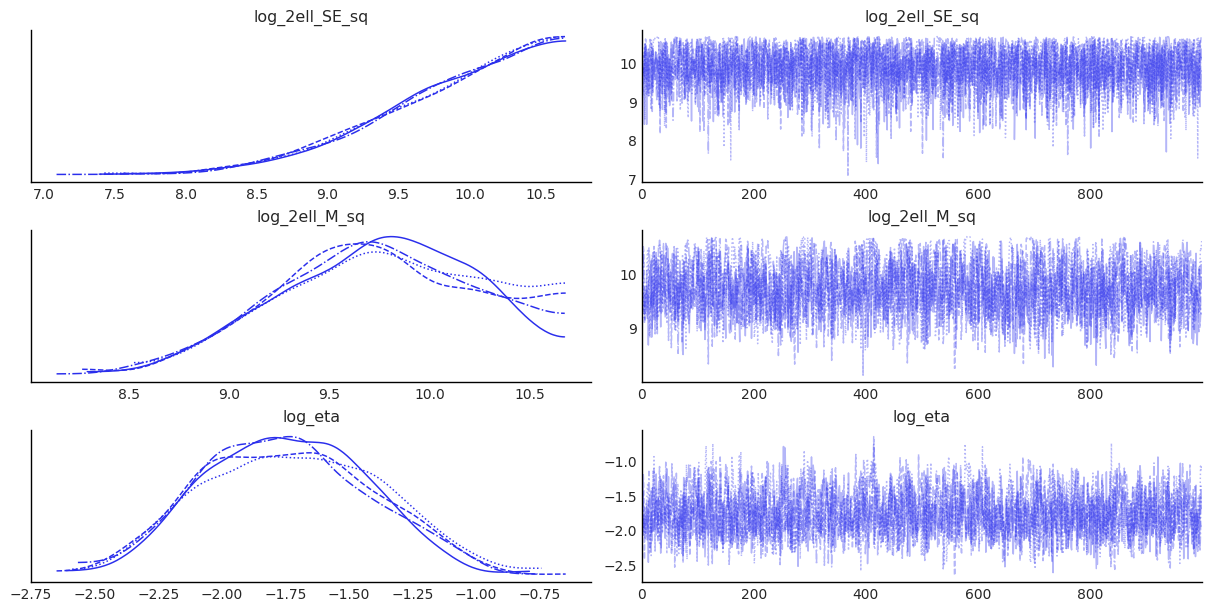

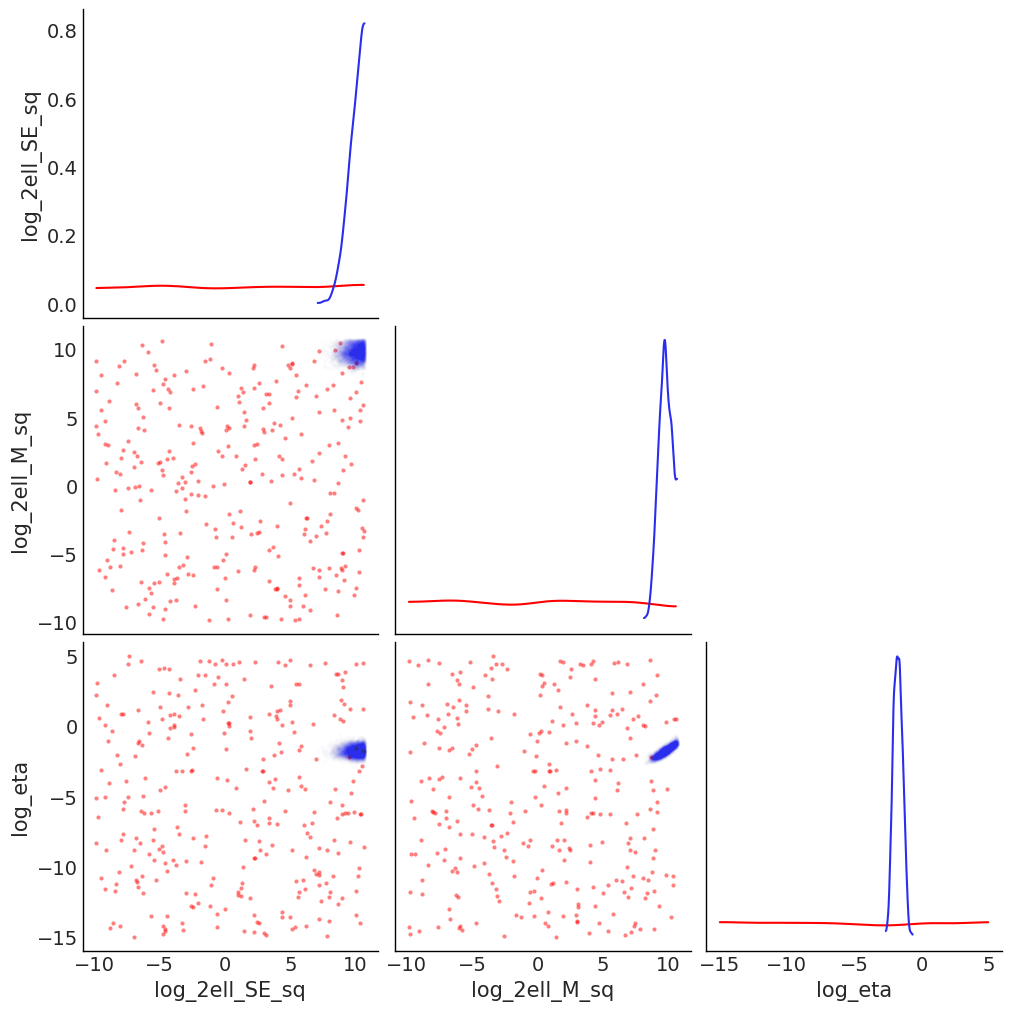

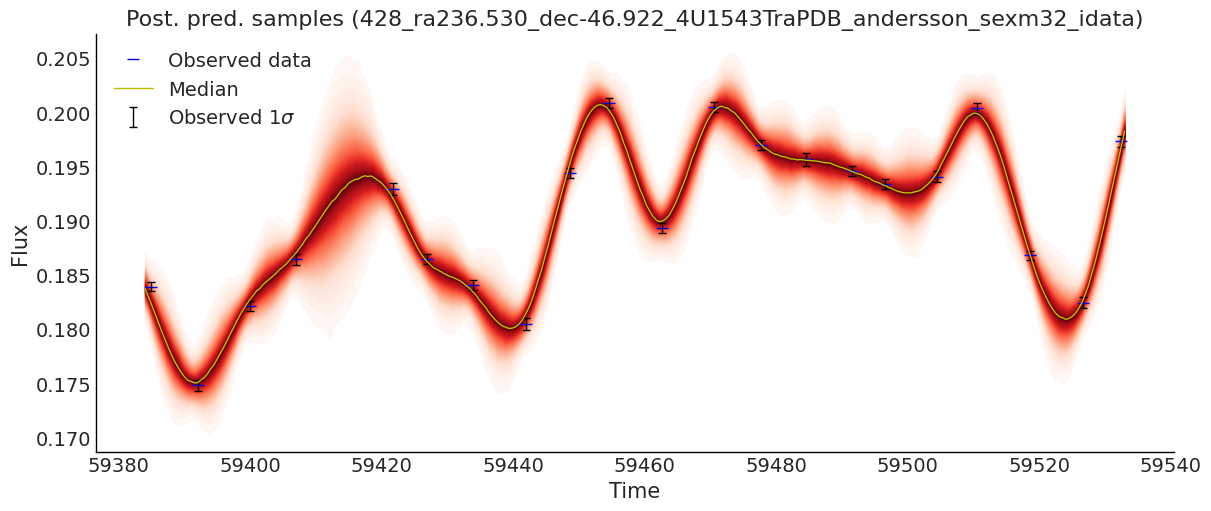

In [86]:
ufn.plot_traces(sexm32_trace_path, variable_names)
ufn.plot_priorpost_cnr(sexm32_trace_path, variable_names)
ufn.plot_postpred_samples(sexm32_trace_path, csv_path)

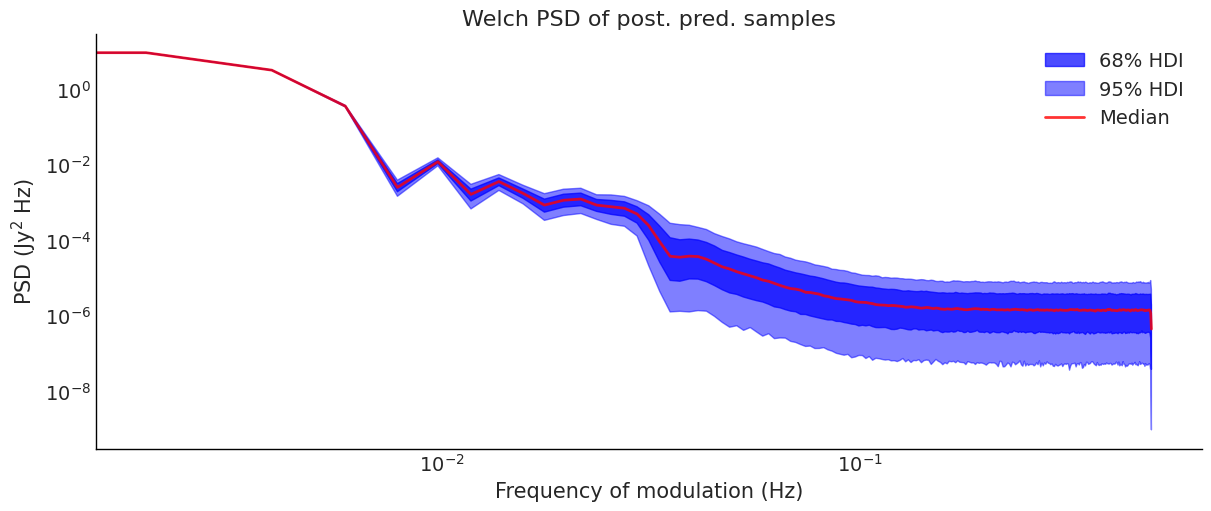

In [87]:
ufn.plot_welch_psd(sexm32_trace);